# MNIST Dataset & Data Loaders

Let's start by downloading the MNIST dataset and setting up data loaders to work with it.

Almost all of us begin learning machine learning by tackling the classic MNIST (Modified National Institute of Standards and Technology) dataset problem - recognizing handwritten digits. This is the same problem that LeCun et al. addressed in 1998 (and demonstrated the strong performance of a deep learning with convolutional neural networks) in their well-known paper, “Gradient-Based Learning Applied to Document Recognition.”

In this post, I’d like to explore several different implementations. My main goal is to present various alternatives to the original approach, while also learning — and helping readers learn — how to implement digit recognition using modern tools. Along the way, I’ll occasionally highlight what’s happening behind the scenes of these tools.

## Download Data

Handling data is challenging on many levels. When working with data that fits on a single machine, it's already difficult to store, read, and split it in a way that makes it easy to feed into a model. This often requires writing a significant amount of glue code. 

Once you exceed the capacity of a single machine and move to data-parallel training, a whole new set of challenges arises — such as managing distributed storage, optimizing caching and networking, and fine-tuning data loaders to keep modern GPUs fed efficiently. And that’s not even touching on pre-training tasks like data collection, storage, cleaning, indexing, and featurization, which could easily fill an entire article on their own (and happen to be my area of expertise in the AI field).

In [8]:
%%bash
mkdir -p data
curl -L -o data/mnist-dataset.zip https://www.kaggle.com/api/v1/datasets/download/hojjatk/mnist-dataset
unzip data/mnist-dataset.zip -d data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22.0M  100 22.0M    0     0  5915k      0  0:00:03  0:00:03 --:--:-- 6887k


Archive:  data/mnist-dataset.zip
  inflating: data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: data/t10k-images.idx3-ubyte  
  inflating: data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: data/t10k-labels.idx1-ubyte  
  inflating: data/train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: data/train-images.idx3-ubyte  
  inflating: data/train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: data/train-labels.idx1-ubyte  


In [9]:
%%bash
tree -sh data/

[ 352]  data/
├── [ 22M]  mnist-dataset.zip
├── [  96]  t10k-images-idx3-ubyte
│   └── [7.5M]  t10k-images-idx3-ubyte
├── [7.5M]  t10k-images.idx3-ubyte
├── [  96]  t10k-labels-idx1-ubyte
│   └���─ [9.8K]  t10k-labels-idx1-ubyte
├── [9.8K]  t10k-labels.idx1-ubyte
├���─ [  96]  train-images-idx3-ubyte
│   └── [ 45M]  train-images-idx3-ubyte
├── [ 45M]  train-images.idx3-ubyte
├── [  96]  train-labels-idx1-ubyte
│   └── [ 59K]  train-labels-idx1-ubyte
└── [ 59K]  train-labels.idx1-ubyte

5 directories, 9 files


## Construct Data Loaders

I really like FastAI because it helps build prototypes quickly and validate ideas. However, since I’ll be using PyTorch as the foundation, I’ll create the dataset using PyTorch and then pass it to the FastAI dataloader. This approach will make it easier to reuse the dataset later in a pure PyTorch implementation.

In [245]:
# Load MNIST data

import numpy as np
import struct

class MnistDataloader:
    def __init__(self, training_images_filepath: str, training_labels_filepath: str,
                 test_images_filepath: str, test_labels_filepath: str) -> None:
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath: str, labels_filepath: str):
        """
        Reads and returns images and labels from MNIST dataset files.
        
        Parameters:
            images_filepath (str): Path to the MNIST image file.
            labels_filepath (str): Path to the MNIST label file.
        
        Returns:
            tuple: A tuple containing NumPy arrays (images, labels).
        """
        # Read labels
        with open(labels_filepath, 'rb') as f:
            header = f.read(8)
            magic, num_labels = struct.unpack(">II", header)
            if magic != 2049:
                raise ValueError(f"Label file magic number mismatch: expected 2049, got {magic}")
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        
        # Read images
        with open(images_filepath, 'rb') as f:
            header = f.read(16)
            magic, num_images, rows, cols = struct.unpack(">IIII", header)
            if magic != 2051:
                raise ValueError(f"Image file magic number mismatch: expected 2051, got {magic}")
            images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
        
        return images, labels
    
    def load_data(self):
        """
        Loads the training and testing data from the provided filepaths.
        
        Returns:
            tuple: ((x_train, y_train), (x_test, y_test))
        """
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return x_train, y_train, x_test, y_test

In [246]:
x_train, y_train, x_test, y_test = MnistDataloader(
    training_images_filepath='data/train-images-idx3-ubyte/train-images-idx3-ubyte', 
    training_labels_filepath='data/train-labels-idx1-ubyte/train-labels-idx1-ubyte',
    test_images_filepath='data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte', 
    test_labels_filepath='data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'
).load_data()
print(f"The shape of the training set: {x_train.shape}")
print(f"The shape of the test set: {x_test.shape}")

The shape of the training set: (60000, 28, 28)
The shape of the test set: (10000, 28, 28)


In [247]:
y_train

array([5, 0, 4, ..., 5, 6, 8], shape=(60000,), dtype=uint8)

In [248]:
import pandas as pd
import numpy as np

In [251]:
# Show a random element from a training set.

df = pd.DataFrame(x_train[50])
df.style.set_properties(**{'font-size':'8pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,12,56,140,126,175,200,96,2,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,35,166,238,254,246,242,253,246,254,67,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,184,182,146,127,70,30,45,36,215,175,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,207,246,14,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55,251,169,1,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,215,232,20,0,0,0,0,0,0,0,0,0,0


In [252]:
import torch
import numpy as np
from fastai.vision.core import PILImage

In [253]:
# Create a PyTorch dataset

class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images  # Expecting shape: (N, 28, 28)
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        arr = self.images[idx]  # shape (28, 28)
        # For grayscale, add a channel dimension (1, 28, 28)
        if arr.ndim == 2:
            arr = arr[None, :, :]
        # Convert to tensor and normalize to range [0,1]
        tensor_img = torch.tensor(arr, dtype=torch.float32) / 255.0
        # If using a model like resnet18 expecting 3 channels, repeat the channel dimension
        if tensor_img.shape[0] == 1:
            tensor_img = tensor_img.repeat(3, 1, 1)
        # Ensure label is a number, not a numpy type
        label = int(self.labels[idx])
        return tensor_img, label

In [254]:
# Create the training and validation datasets
train_ds = MNISTDataset(x_train, y_train)
valid_ds = MNISTDataset(x_test, y_test)

In [255]:
img_arr, label = train_ds[50]
print(f"Label: {label}")
df = pd.DataFrame(img_arr[0]) # I've added three channels, but the only one has sense TBH.
df.style.set_properties(**{'font-size':'8pt'}).background_gradient('Greys')

Label: 3


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047059,0.219608,0.549020,0.494118,0.686275,0.784314,0.376471,0.007843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137255,0.650980,0.933333,0.996078,0.964706,0.949020,0.992157,0.964706,0.996078,0.262745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.721569,0.713726,0.572549,0.498039,0.274510,0.117647,0.176471,0.141176,0.843137,0.686275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.811765,0.964706,0.054902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.215686,0.984314,0.662745,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043137,0.843137,0.909804,0.078431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [256]:
# Create FastAI DataLoaders
dls = ImageDataLoaders.from_dsets(train_ds, valid_ds)
dls.c = 10  # Set the number of classes for the DataLoaders

# Train ResNet-based Model

In [89]:
from fastai.vision.all import vision_learner, resnet18, F, accuracy

In [90]:
learn = vision_learner(
    dls,
    resnet18,
    pretrained=False,
    loss_func=F.cross_entropy,
    metrics=accuracy)

In [92]:
learn.fit(5, lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.152374,0.119393,0.967900,04:55
1,0.086497,0.058563,0.984700,04:55
2,0.092581,0.042859,0.987200,04:54
3,0.069151,0.047238,0.987100,04:55
4,0.068270,0.040619,0.988500,04:55


# Train Hand-crafted Sequntial Model

Let's break it down a bit. In the previous step, we used a pre-built architecture from the ResNet model. Here's a quick overview:

In [257]:
m = resnet18()
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We can build a similar model ourselves! It will take some time and space, so let's create a shorter and simpler version instead.  

In the previous setup, we expanded the image's channels to match a specific model architecture. We don't need to do that here, so the dataset implementation will be a bit simpler.

In [277]:
from torch import nn

In [304]:
# Create a PyTorch dataset

class MNISTDataset2(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images  # Expecting shape: (N, 28, 28)
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        arr = self.images[idx]  # shape (28, 28)
        # Convert to tensor and normalize to range [0,1]
        tensor_img = torch.tensor(arr, dtype=torch.float32).reshape(-1) / 255.0  # shape (784, )
        
        # Ensure label is a number, not a numpy type
        label = int(self.labels[idx])
        return tensor_img, label

In [305]:
train_ds = MNISTDataset2(x_train, y_train)
valid_ds = MNISTDataset2(x_test, y_test)

In [306]:
# # Dataloaders Using PyTorch
# from torch.utils.data import DataLoader
# from fastai.data.core import DataLoaders

# # 1. make your PyTorch DataLoaders
# bs = 64                                  # whatever batch‑size you like
# train_dl = DataLoader(train_ds, bs, shuffle=True, pin_memory=True)
# valid_dl = DataLoader(valid_ds, bs, shuffle=False, pin_memory=True)

# # 2. pack them into a fastai DataLoaders
# dls = DataLoaders(train_dl, valid_dl)

In [307]:
# Dataloaders Using FastAI
from fastai.data.core import DataLoaders

dls = DataLoaders.from_dsets(train_ds, valid_ds,
                             bs=64,                # batch‑size
                             shuffle_train=True)   # shuffle only the training set

In [308]:
simple_net = nn.Sequential(
    nn.Linear(28*28,60),
    nn.ReLU(),
    nn.Linear(60,10)
)

In [309]:
from fastai.learner import Learner, L
from fastai.optimizer import SGD
from fastai.losses import CrossEntropyLossFlat

By switching to `CrossEntropyLossFlat()`, we get both the convenience of automatic shape handling and seamless integration with fastai’s prediction/metric system.

In [310]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [311]:
learn.fit(20, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.294922,0.275525,0.920000,00:00
1,0.199998,0.206535,0.940400,00:00
2,0.170349,0.166199,0.952000,00:00
3,0.146461,0.140720,0.959000,00:00
4,0.120906,0.128438,0.963000,00:00
5,0.110094,0.127835,0.960500,00:00
6,0.094452,0.112839,0.966800,00:00
7,0.088716,0.103456,0.968000,00:00
8,0.077021,0.098348,0.969400,00:00
9,0.076273,0.097184,0.970600,00:00


In [312]:
from matplotlib import pyplot as plt

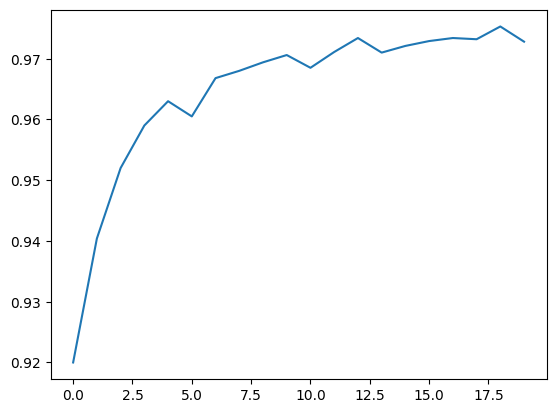

In [313]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [314]:
# grab the image+label tuple
item = train_ds[50]     # == (tensor_img, int_label)

# now let Fastai unpack it properly
pred_cat, pred_idx, probs = learn.predict(item)


print("→  Fastai thinks it’s:", pred_cat)         # a TensorCategory, e.g. '7'
print("→  as an int:", int(pred_cat))             # 7
print("→  probability:", float(probs[pred_idx]))  # e.g. 0.82

→  Fastai thinks it’s: tensor(3)
→  as an int: 3
→  probability: 0.999902606010437


# Our Own Learner

Let's take it a step further and create our own learner class.

Let's implement training loop within a `fit` function. The purpose of the training loop is to minimize the loss function. The loop can be split into four steps:
1. Using an initial set of randomly selected parameters, make a prediction: $Y_{pred} = model(X)$ 
2. Calculate the loss using previously calculated prediction and previously defined loss function: $loss = loss\_func(Y_{pred}, Y)$ 
3. Perform backpropagation with with the computed loss: `loss.backward()`
4. Update the weights: `parameters -= parameters * lr`

ML frameworks like already include built-in training loops. However, it's helpful to understand how they work behind the scenes. Let's begin with the learner interface.

In [404]:
# Initialize parameters and mark them as "requires_grad" since these are the tensors we'll be differentiating with respect to.
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

In [405]:
w1 = init_params((28*28, 30))
b1 = init_params(30)
w2 = init_params((30, 10))  # 10 output numbers in our NN
b2 = init_params(10)

In [406]:
def simple_net(xb):  # "xb" stands for "batch of inputs x"
    res = xb@w1 + b1
    res = F.relu(res)
    res = res@w2 + b2
    return res

In [407]:
x = torch.stack([x for x, _ in train_ds])
y = torch.tensor([y for _, y in train_ds])
print(f"The shape of training examples: {training_examples.shape}, the shape of labels: {y.shape}")

The shape of training examples: torch.Size([60000, 784]), the shape of labels: torch.Size([60000])


In [408]:
loss_fn = CrossEntropyLossFlat()
lr = 0.1

def apply_step(w1, b1, w2, b2):
    preds = simple_net(training_examples)
    loss = loss_fn(preds, y)
    loss.backward()
    w1.data -= lr * w1.grad.data
    w1.grad = None
    b1.data -= lr * b1.grad.data
    b1.grad = None
    w2.data -= lr * w2.grad.data
    w2.grad = None
    b2.data -= lr * b2.grad.data
    b2.grad = None
    print(loss.item())
    return preds

In [409]:
for i in range(20):
    preds = apply_step(w1, b1, w2, b2)

64.97019958496094
42.93716812133789
29.093425750732422
23.82625389099121
20.942155838012695
18.81755256652832
17.177536010742188
15.805498123168945
14.621469497680664
13.596285820007324
12.705423355102539
11.925715446472168
11.240151405334473
10.633559226989746
10.093964576721191
9.610675811767578
9.176405906677246
8.783842086791992
8.42672061920166
8.10017204284668


In [415]:
# We can turn your logits into predicted class‐indices with!
pred_classes = preds.argmax(dim=1)

In [418]:
print(preds[50])
print(pred_classes[50])

tensor([ -8.0793, -38.0559,  -5.0226,  10.8757, -14.3885, -17.5152,   8.0000,
        -58.7696, -30.8996,  -6.7066], grad_fn=<SelectBackward0>)
tensor(3)
